In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split, KFold

import math
import torch
import tqdm
import gpytorch

# Preprocesamiento

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.columns

Index(['Date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5',
       'Atmospheric Pressure', 'Precipitation', 'Relative Humidity', 'SO2',
       'Solar Radiation', 'Temperature', 'Wind Speed', 'Wind Direction',
       'Nombre_Estacion', 'Clave_Estacion', 'Latitude', 'Longitude'],
      dtype='object')

In [3]:
# # Plot estimated KDE of the data

# numeric_columns = dataset.select_dtypes(include=[float, int]).columns
# num_columns = len(numeric_columns)

# fig, axes = plt.subplots(nrows = num_columns // 4 + 1, ncols= 4, figsize=(20, 10))

# for i, column in enumerate(numeric_columns):
#     sns.kdeplot(dataset[column], ax=axes[i // 4, i % 4])
#     axes[i // 4, i % 4].set_title(column)
# plt.tight_layout()
# plt.savefig('kde_original.png')

In [4]:
# # Plot estimated KDE of the data
# rng = np.random.RandomState(42)
# numeric_columns = dataset.select_dtypes(include=[float, int]).columns
# num_columns = len(numeric_columns)

# # box_cox = PowerTransformer(method='box-cox')
# yeo_johnson = PowerTransformer(method='yeo-johnson')
# qt = QuantileTransformer(n_quantiles=1000, output_distribution="normal", random_state=rng)



# for transform in [yeo_johnson, qt]:
#     temp = dataset.copy()
#     fig, axes = plt.subplots(nrows = num_columns // 4 + 1, ncols= 4, figsize=(20, 10))

#     png_name = {
#         yeo_johnson: 'yeo_johnson',
#         qt: 'quantile'
#     }

#     for i, column in enumerate(numeric_columns):
#         transformed_column = StandardScaler().fit_transform(temp[column].values.reshape(-1, 1))
#         temp[column] = transform.fit_transform(transformed_column)
#         sns.kdeplot(temp[column], ax=axes[i // 4, i % 4])
#         axes[i // 4, i % 4].set_title(column)
    
#     plt.tight_layout()

#     plt.savefig(f'{png_name[transform]}_kde.png')
        

In [10]:
tec_loc = (25.650390, -100.289900)
# date = min(dataset['Date'])

# dataset_on_date = dataset[dataset['Date'] == date]

X = dataset.drop(columns=['Date', 'PM2.5', 'Nombre_Estacion', 'Clave_Estacion'])
y = dataset['PM2.5']

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(X_train)

          CO    NO   NO2   NOX    O3   PM10  Atmospheric Pressure  \
0       2.36  19.8  48.4  68.0   5.0  142.0                 715.7   
1       2.29  10.8  44.5  55.1   6.0  168.0                 715.5   
2       2.71  28.3  47.1  75.2   4.0  203.0                 715.4   
3       2.31  19.6  42.1  61.5   5.0  262.0                 715.1   
5       1.30   5.4  25.6  30.9   8.0  133.0                 715.0   
...      ...   ...   ...   ...   ...    ...                   ...   
205800  0.53   3.1   8.2  11.2  40.0  108.0                 705.4   
205801  0.56   2.9   9.9  12.7  36.0   59.0                 705.8   
205802  0.57   3.0  10.3  13.2  33.0   56.0                 706.3   
205803  0.74   9.8  21.1  30.9  19.0   54.0                 706.8   
205804  0.68   3.0   9.2  12.0  27.0   94.0                 707.3   

        Precipitation  Relative Humidity  SO2  Solar Radiation  Temperature  \
0                 0.0               59.0  4.0            0.000        21.65   
1            

In [6]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

train_x_distributional = torch.stack((train_x_mean, (train_x_stdv**2).log()), dim=1)

In [7]:
from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(GaussianSymmetrizedKLKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_distributional, train_y, likelihood)

In [8]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.277   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.249   lengthscale: 0.826   noise: 0.576
Iter 3/500 - Loss: 1.179   lengthscale: 0.953   noise: 0.475
Iter 4/500 - Loss: 1.148   lengthscale: 1.099   noise: 0.389
Iter 5/500 - Loss: 1.133   lengthscale: 1.263   noise: 0.318
Iter 6/500 - Loss: 1.111   lengthscale: 1.439   noise: 0.262
Iter 7/500 - Loss: 1.107   lengthscale: 1.616   noise: 0.222
Iter 8/500 - Loss: 1.128   lengthscale: 1.794   noise: 0.196
Iter 9/500 - Loss: 1.130   lengthscale: 1.977   noise: 0.184
Iter 10/500 - Loss: 1.112   lengthscale: 2.174   noise: 0.181
Iter 11/500 - Loss: 1.097   lengthscale: 2.385   noise: 0.184
Iter 12/500 - Loss: 1.086   lengthscale: 2.606   noise: 0.191
Iter 13/500 - Loss: 1.071   lengthscale: 2.837   noise: 0.200
Iter 14/500 - Loss: 1.055   lengthscale: 3.074   noise: 0.209
Iter 15/500 - Loss: 1.045   lengthscale: 3.317   noise: 0.214
Iter 16/500 - Loss: 1.040   lengthscale: 3.564   noise: 0.215
Iter 17/500 - Los

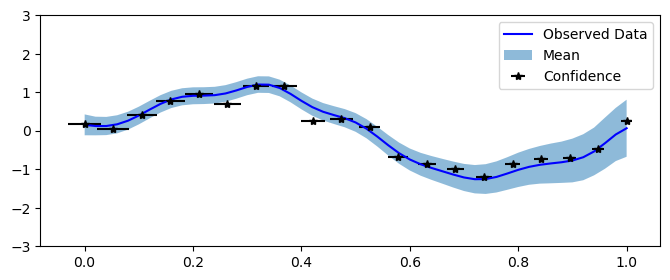

In [9]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    test_x_distributional = torch.stack((test_x, (1e-3 * torch.ones_like(test_x)).log()), dim=1)
    observed_pred = likelihood(model(test_x_distributional))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])